Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [2]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

In [8]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [10]:
import pandas as pd

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [11]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [21]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [16]:
df["NEIGHBORHOOD"].value_counts()

OTHER                      19117
FLUSHING-NORTH               685
UPPER EAST SIDE (59-79)      465
UPPER EAST SIDE (79-96)      410
BEDFORD STUYVESANT           408
BOROUGH PARK                 376
UPPER WEST SIDE (59-79)      350
GRAMERCY                     323
ASTORIA                      312
FOREST HILLS                 298
UPPER WEST SIDE (79-96)      296
Name: NEIGHBORHOOD, dtype: int64

In [19]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [113]:
df = df[df["BUILDING_CLASS_CATEGORY"] == '01 ONE FAMILY DWELLINGS']

In [118]:
df = df[(df['SALE_PRICE'] >= 100000) & 
        (df['SALE_PRICE'] <= 2000000)]

In [119]:
df2 = df.copy()

In [120]:
df2["EASE-MENT"].value_counts()

Series([], Name: EASE-MENT, dtype: int64)

In [121]:
df2.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3164.000000,3164.000000,0.0,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.0,3.164000e+03
mean,6908.597029,75.847029,NaN,11027.442162,0.987358,0.015803,1.003161,1469.718394,1943.639697,1.0,6.281899e+05
std,3964.333893,160.779187,NaN,482.591574,0.114537,0.127241,0.172362,586.645088,26.679176,0.0,2.969134e+05
min,21.000000,1.000000,NaN,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.000000e+05
25%,4003.250000,21.000000,NaN,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.450000e+05
50%,6269.500000,42.000000,NaN,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.650000e+05
75%,10206.250000,69.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,NaN,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,2.000000e+06


In [122]:
df.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
BUILDING_CLASS_CATEGORY,3164,1,01 ONE FAMILY DWELLINGS,3164
APARTMENT_NUMBER,1,1,RP.,1
TAX_CLASS_AT_PRESENT,3164,2,1,3123
BOROUGH,3164,5,4,1585
NEIGHBORHOOD,3164,6,OTHER,3001
BUILDING_CLASS_AT_TIME_OF_SALE,3164,11,A1,1189
BUILDING_CLASS_AT_PRESENT,3164,13,A1,1188
SALE_DATE,3164,91,01/31/2019,78
LAND_SQUARE_FEET,3164,1037,"4,000",290
ADDRESS,3164,3148,94 CELESTE COURT,2


In [123]:
df2 = df2.drop(["BUILDING_CLASS_CATEGORY","BUILDING_CLASS_AT_PRESENT","BUILDING_CLASS_AT_TIME_OF_SALE","APARTMENT_NUMBER","ADDRESS","EASE-MENT","TAX_CLASS_AT_TIME_OF_SALE","TAX_CLASS_AT_PRESENT"],axis=1)

In [125]:
# df2["SALE_PRICE"].value_counts()

In [104]:
import numpy as np

In [105]:
# #removed the outlying prices. what is unusual here is that on the lower end the price "0" accounted for the bottom 30% of the data!

# df2 = df2[(df2['SALE_PRICE'] >= np.percentile(df2['SALE_PRICE'], 30)) & 
#         (df2['SALE_PRICE'] <= np.percentile(df2['SALE_PRICE'], 95))]

In [126]:
df2.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
44,3,OTHER,5495,801,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,550000,01/01/2019
61,4,OTHER,7918,72,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,200000,01/01/2019
78,2,OTHER,4210,19,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,810000,01/02/2019
108,3,OTHER,5212,69,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,125000,01/02/2019
111,3,OTHER,7930,121,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,620000,01/02/2019


In [127]:
df2 = df2[df2["LAND_SQUARE_FEET"] != '########']

In [128]:
#converting to datetime and converting string column to float

df2["SALE_DATE"] = pd.to_datetime(df2["SALE_DATE"], infer_datetime_format=True)
df2["LAND_SQUARE_FEET"] = df2["LAND_SQUARE_FEET"].str.replace(',', '').astype(float)


    

In [129]:
df2.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
44,3,OTHER,5495,801,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,550000,2019-01-01
61,4,OTHER,7918,72,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,200000,2019-01-01
78,2,OTHER,4210,19,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,810000,2019-01-02
108,3,OTHER,5212,69,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,125000,2019-01-02
111,3,OTHER,7930,121,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,620000,2019-01-02


In [110]:
# !pip install category_encoders

In [111]:
df3 = df2.copy()

In [132]:
#performing One-Hot Encoding on neighborhoods, not sure this was a good idea. Need to learn more about this 
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
df3["NEIGHBORHOOD"] = encoder.fit_transform(df3["NEIGHBORHOOD"])

In [133]:
#did I do the right thing by one-hot encoding this

df3["NEIGHBORHOOD"].value_counts()

1    12776
0     2207
Name: NEIGHBORHOOD, dtype: int64

### Looking at SelectKBest now

In [134]:
train = df3[(df3["SALE_DATE"] >= "2019-01-01") & (df3["SALE_DATE"] <= "2019-03-31")]
test = df3[(df3["SALE_DATE"] >= "2019-04-01") & (df3["SALE_DATE"] <= "2019-04-30")]

In [154]:
train = train[train["LAND_SQUARE_FEET"].notna()]
test = test[test["LAND_SQUARE_FEET"].notna()]

In [155]:
#seems useful for prediction

train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
0    961307.552493
1    748475.655670
Name: SALE_PRICE, dtype: float64

In [157]:
target = "SALE_PRICE"
others = ["SALE_DATE","YEAR_BUILT"] 
features = train.columns.drop([target] + others)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [159]:
X_train.describe()

,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET
count,11617.000000,11617.000000,11617.000000,11617.000000,11617.000000,11617.000000,11617.000000,11617.000000,11617.000000
mean,0.853232,4483.431523,350.541017,10788.739520,1.210726,0.158389,1.550400,4727.730567,1781.785745
std,0.353889,3695.987554,613.495339,1088.688717,3.581477,1.476940,5.527999,20696.937289,8025.908016
min,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,1.000000,1392.000000,21.000000,10308.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,3594.000000,49.000000,11210.000000,1.000000,0.000000,1.000000,1948.000000,1161.000000
75%,1.000000,6654.000000,400.000000,11362.000000,2.000000,0.000000,2.000000,3000.000000,1920.000000
max,1.000000,16350.000000,9022.000000,11697.000000,155.000000,67.000000,156.000000,484555.000000,244619.000000


In [162]:
# Select the 9 features that best correlate with the target
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before
selector = SelectKBest(score_func=f_regression, k=5)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((11617, 5), (3321, 5))

In [163]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH
NEIGHBORHOOD
BLOCK
LOT
GROSS_SQUARE_FEET


Features not selected:
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET


In [164]:
#this feature scaling reveals we get an the lowest MAE with 9 features

# How many features should be selected?
# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $434,628 

2 features
Test MAE: $425,142 

3 features
Test MAE: $423,841 

4 features
Test MAE: $423,009 

5 features
Test MAE: $419,514 

6 features
Test MAE: $418,894 

7 features
Test MAE: $418,989 

8 features
Test MAE: $418,430 

9 features
Test MAE: $418,434 

10 features
Test MAE: $418,464 



In [166]:
#doing feature scaling below, but entirely sure I want to apply to my existing data

from sklearn.preprocessing import scale
from sklearn.datasets import load_boston

In [167]:
boston = load_boston()

In [175]:
df_b = pd.DataFrame(boston.data, columns=boston.feature_names)

In [176]:
df_b.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [177]:
boston.scaled = scale(boston.data)

In [178]:
df_bs = pd.DataFrame(boston.scaled, columns=boston.feature_names)

In [179]:
df_bs.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [221]:
#preparing dataframe for scale

df4 = df3.copy()
df4.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE
44,3,1,5495,801,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,550000,2019-01-01
61,4,1,7918,72,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,200000,2019-01-01
65,1,1,691,1130,10011.0,1.0,0.0,1.0,18975.0,1077.0,2013.0,2000000,2019-01-02
66,1,1,1347,18,10022.0,0.0,0.0,0.0,0.0,0.0,1960.0,330000,2019-01-02
67,1,0,1491,62,10075.0,0.0,0.0,0.0,0.0,0.0,1925.0,600000,2019-01-02


In [222]:
df4 = df4.drop(["YEAR_BUILT","SALE_DATE"],axis=1)

df4.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,SALE_PRICE
44,3,1,5495,801,11230.0,1.0,0.0,1.0,6800.0,1325.0,550000
61,4,1,7918,72,11427.0,1.0,0.0,1.0,4000.0,2001.0,200000
65,1,1,691,1130,10011.0,1.0,0.0,1.0,18975.0,1077.0,2000000
66,1,1,1347,18,10022.0,0.0,0.0,0.0,0.0,0.0,330000
67,1,0,1491,62,10075.0,0.0,0.0,0.0,0.0,0.0,600000


In [223]:
df4.data = scale(df4)

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [224]:
df5 = pd.DataFrame(df4.data,columns=df4.columns)

In [225]:
df5.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,SALE_PRICE
0,0.001532,0.415627,0.270929,0.699884,0.400846,-0.058867,-0.107128,-0.106551,0.096079,-0.068989,-0.404681
1,0.793057,0.415627,0.923037,-0.466954,0.580520,-0.058867,-0.107128,-0.106551,-0.035512,-0.006024,-0.989609
2,-1.581518,0.415627,-1.021985,1.226482,-0.710942,-0.058867,-0.107128,-0.106551,0.668264,-0.092089,2.018589
3,-1.581518,0.415627,-0.845434,-0.553386,-0.700909,-0.325897,-0.107128,-0.268908,-0.223499,-0.192405,-0.772350
4,-1.581518,-2.406004,-0.806679,-0.482960,-0.652571,-0.325897,-0.107128,-0.268908,-0.223499,-0.192405,-0.321120


In [230]:
#cleaning NaN's from dirty Column

df5 = df5[df5["LAND_SQUARE_FEET"].notna()]
df4 = df4[df4["LAND_SQUARE_FEET"].notna()]

In [234]:
#insanely high number, what am I doing wrong here? this data is not scaled 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df5[features]
y = df5["SALE_PRICE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

0.8664648367951227
0.8411441412545014


In [235]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

X = df5[features]
y = df5["SALE_PRICE"]

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

0.8662870583724112

In [236]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 0.8411441412545013
1 0.8411443502582348
2 0.8411445600987109
3 0.841144770775314
4 0.8411449822874306
5 0.8411451946344474
6 0.8411454078157536
7 0.84114562183074
8 0.8411458366787986
9 0.8411460523593228
10 0.8411462688717081
11 0.8411464862153509
12 0.8411467043896494
13 0.8411469233940035
14 0.8411471432278145
15 0.8411473638904844
16 0.8411475853814181
17 0.8411478077000208
18 0.8411480308456998
19 0.8411482548178635
20 0.841148479615922
21 0.8411487052392868
22 0.8411489316873708
23 0.8411491589595884
24 0.8411493870553551
25 0.8411496159740884
26 0.8411498457152068
27 0.8411500762781301
28 0.8411503076622799
29 0.8411505398670793
30 0.841150772891952
31 0.8411510067363237
32 0.8411512413996214
33 0.8411514768812736
34 0.8411517131807096
35 0.8411519502973607
36 0.841152188230659
37 0.8411524269800386
38 0.8411526665449341
39 0.8411529069247826
40 0.8411531481190211
41 0.8411533901270889
42 0.8411536329484262
43 0.8411538765824748
44 0.8411541210286775
45 0.8411543662864789
46 0

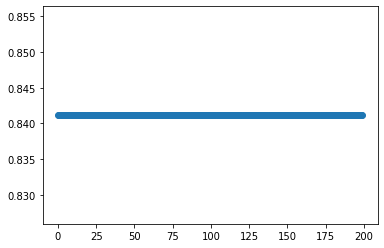

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);
plt.xlim()